# Scripts related to venv
### Open a terminal
- .venv\Scripts\activate
- py -m pip install --upgrade pip
- py -m pip install requests
- py -m pip freeze > requirements.txt
- py -m pip install -r requirements.txt

# AWS Article
- https://induraj2020.medium.com/how-to-access-the-s3-bucket-using-python-ecdbe5ebc45f

# Music Genre Classification
In this notebook I tried to learn the basic concepts of neural networks and use it to classify the music files in dataset. Majorly this notebook can be divided into 3 parts:

   1) Using ANN 

   2) Tackling overfitting with ANN

   3) Using CNN


Also to read the dataset I have used librosa library which only read files <1Mb and one file is greater than the size giving error due to which I have ignored it. The dataset contains the following genres, the keys being the prediction targets
    
    0: "disco",
    1: "metal",
    2: "reggae",
    3: "blues",
    4: "rock",
    5: "classical",
    6: "jazz",
    7: "hiphop",
    8: "country",
    9: "pop"


In [61]:
import os
import librosa
from PIL import Image
import boto3
import math
import json
import matplotlib.pyplot as plt
import io
import numpy as np
import warnings 
import requests
import pandas as pd
import tensorflow as tf
warnings.filterwarnings("ignore")

In [78]:
def load_image(bucket_name, image_key, target_size=(128, 128)):
    s3 = boto3.client('s3')
    image_data = s3.get_object(Bucket=bucket_name, Key=image_key)['Body'].read()

    image = Image.open(io.BytesIO(image_data)).convert('RGB')

    image = image.resize(target_size)

    return np.array(image) / 255.0

In [79]:
def load_images(bucket_name, dataset_path, target_size=(128, 128)):
    images = []
    labels = []
    label_mapping = {}
    s3 = boto3.client('s3')
    paginator = s3.get_paginator('list_objects_v2')

    for i, page in enumerate(paginator.paginate(Bucket=bucket_name, Prefix=dataset_path)):
        if 'Contents' not in page:
            continue
        
        for obj in page['Contents']:
            image_key = obj['Key']
            if image_key.endswith(".png"):
                genre_label = image_key.split('/')[-2]

                if genre_label not in label_mapping:
                    label_mapping[genre_label] = len(label_mapping)

                image_array = load_image(bucket_name, image_key, target_size)

                images.append(image_array)
                labels.append(label_mapping[genre_label])

    return np.array(images), np.array(labels)
        

In [80]:
images, labels = load_images(bucket_name='flights12345', dataset_path=r"Data/images_original")

## Create training/validation/testing


In [113]:
np.random.seed(123)
train_size = int(0.7 * 999)
test_size = int(0.15 * 999)
validation_size = int(0.15 * 999)

groups = np.array([0] * train_size + [1] * test_size + [2] * validation_size)
np.random.shuffle(groups)

In [114]:
train_images, validation_images, test_images = [], [], []
train_labels, validation_labels, test_labels = np.array([]), np.array([]), np.array([])

for i, group in enumerate(groups):
    if group == 0:
        train_images.append(images[i])
        train_labels = np.append(train_labels, int(labels[i]))
    elif group == 1:
        validation_images.append(images[i])
        validation_labels = np.append(validation_labels, int(labels[i]))
    else:
        test_images.append(images[i])
        test_labels = np.append(test_labels, int(labels[i]))

In [115]:
train_images, validation_images, test_images = np.array(train_images), np.array(validation_images), np.array(test_images)

## Create IMFs


In [ ]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

def find_extrema(signal):
    maxima = []
    minima = []
    
    for i in range(1, len(signal) - 1):
        if signal[i-1] < signal[i] > signal[i+1]:
            maxima.append(i)
        elif signal[i-1] > signal[i] < signal[i+1]:
            minima.append(i)
            
    return np.array(maxima), np.array(minima)

def compute_envelope(t, signal, extrema):
    if len(extrema) > 0:
        if extrema[0] > 0:
            extrema = np.r_[0, extrema]
        if extrema[-1] < len(signal) - 1:
            extrema = np.r_[extrema, len(signal) - 1]
            
        return CubicSpline(extrema, signal[extrema])(t)
    return np.zeros_like(signal)

def IMFextraction(signal, max_iterations=10, tolerance=0.1):
    s = signal.copy()
    l = np.arange(len(signal))
    
    for _ in range(max_iterations):
        maxima, minima = find_extrema(s)
        
        if len(maxima) + len(minima) < 3:
            break
            
        upper_envelope = compute_envelope(l, s, maxima)
        lower_envelope = compute_envelope(l, s, minima)
        mean_envelope = (upper_envelope + lower_envelope) / 2
        
        s_previous = s.copy()
        s = s - mean_envelope
        
        if np.all(np.abs((s_previous - s) / (s_previous + np.finfo(float).eps)) < tolerance):
            break
            
    return s

def decompose_to_imfs(signal, extract_imf, num_imfs=3):
    imfs = []
    residual = signal.copy()
    
    for _ in range(num_imfs):
        imf = extract_imf(residual)
        imfs.append(imf)
        residual = residual - imf
        
    return np.array(imfs)

def process_images_imf(image_set, num_imfs=3, reshape_size=(128, 128, 3)):
    processed_images = []
    
    for img in image_set:
        img_reshaped = img.reshape(reshape_size)
        
        channel_imfs = []
        for channel in range(3):
            channel_data = img_reshaped[:, :, channel].flatten()
            imfs = decompose_to_imfs(channel_data, num_imfs)
            channel_imfs.append(imfs)
            
        processed_images.append(channel_imfs)
    
    return np.array(processed_images)

def visualize_images_imf(original_image, imfs, genre_mapping, label, num_imfs_to_show=3):
    plt.figure(figsize=(15, 5 * (num_imfs_to_show + 1)))
    
    genre_names = {v: k for k, v in genre_mapping.items()}
    genre = genre_names.get(label, "Unknown")
    
    plt.subplot(num_imfs_to_show + 1, 1, 1)
    plt.imshow(original_image.reshape(128, 128, 3))
    plt.title(f'Original Image - Genre: {genre}')
    plt.axis('off')
    
    for i in range(num_imfs_to_show):
        plt.subplot(num_imfs_to_show + 1, 1, i + 2)
        
        imf_image = np.zeros((128, 128, 3))
        for c in range(3):
            imf_image[:, :, c] = imfs[c][i].reshape(128, 128)
            
        plt.imshow(imf_image + 0.5)
        plt.title(f'IMF {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

genre_mapping = {
    "disco": 0,
    "metal": 1,
    "reggae": 2,
    "blues": 3,
    "rock": 4,
    "classical": 5,
    "jazz": 6,
    "hiphop": 7,
    "country": 8,
    "pop": 9
}

def process_and_visualize(train_images, train_labels, num_samples=3, num_imfs=3):
    indices = np.random.choice(len(train_images), num_samples, replace=False)
    
    for idx in indices:
        image = train_images[idx]
        label = train_labels[idx]
        
        imfs = process_images_imf(image.reshape(1, -1), num_imfs)[0]
        
        visualize_images_imf(image, imfs, genre_mapping, label, num_imfs)



## Feed into FCN for feature extraction


In [123]:
inputs = tf.keras.layers.Input(shape=(train_images.shape[1:]))

In [124]:
def create_encoder(inputs):
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.2)(c5)
    c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c5)

    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = tf.keras.layers.Dropout(0.3)(c6)
    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    return c6

In [ ]:
num_classes = 10
def create_decoder(c6):
    x = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c6)
    outputs = tf.keras.layers.GlobalAveragePooling2D()(x)
    return outputs

In [126]:
encoder = create_encoder(inputs)
outputs = create_decoder(encoder)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [127]:
model.compile(optimizer="adam",
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

model.fit(train_images, train_labels, validation_data=(validation_images,validation_labels), batch_size=16, epochs=100, callbacks=callbacks)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.1040 - loss: 2.5366 - val_accuracy: 0.1007 - val_loss: 2.3029
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.0911 - loss: 2.3027 - val_accuracy: 0.0805 - val_loss: 2.3028
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.0715 - loss: 2.3027 - val_accuracy: 0.1007 - val_loss: 2.3027
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.1154 - loss: 2.3016 - val_accuracy: 0.1074 - val_loss: 2.3031
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.1073 - loss: 2.3022 - val_accuracy: 0.1007 - val_loss: 2.3035
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.0942 - loss: 2.3009 - val_accuracy: 0.1074 - val_loss: 2.3034
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.1056 - loss: 2.3074 - val_accuracy: 0.1074 - val_loss: 2.3038
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.1154 - loss: 2.3005 - val_accu

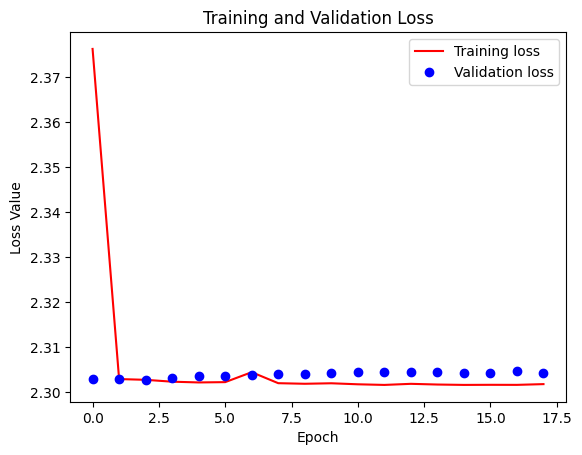

In [129]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

## Feed into SVM/Random Forest for classification